# Train

## Dataset preparation

Import the dataset

In [1]:
import pandas as pd

dataset = pd.read_csv('dataset_train.txt', skipinitialspace=True)
dataset

,EvtNo,ID,Shift,Sigma,Time,Time0,Time1,Time2,Time3,Time4,Time5,Time6,Time7,Time8,Time9,Time10,Time11,Time12,Time13,Time14
0,0,0,-0.000461,1,6,-0.001889,-0.001901,-0.001777,-0.001508,-0.000680,0.000757,0.001979,0.002073,0.001148,0.000191,-0.000053,0.000295,0.000628,0.000545,0.000192
1,0,0,-0.000338,1,7,-0.002025,-0.001901,-0.001631,-0.000804,0.000633,0.001855,0.001950,0.001024,0.000067,-0.000177,0.000171,0.000504,0.000421,0.000068,-0.000155
2,0,0,-0.000219,1,8,-0.002019,-0.001750,-0.000922,0.000515,0.001737,0.001831,0.000906,-0.000051,-0.000295,0.000053,0.000385,0.000303,-0.000050,-0.000273,-0.000370
3,0,0,-0.000137,1,9,-0.001832,-0.001005,0.000432,0.001655,0.001749,0.000824,-0.000133,-0.000377,-0.000030,0.000303,0.000220,-0.000132,-0.000356,-0.000453,-0.000866
4,0,0,-0.000233,1,12,0.001750,0.001845,0.000919,-0.000038,-0.000282,0.000066,0.000399,0.000316,-0.000037,-0.000260,-0.000357,-0.000771,-0.001471,-0.001558,-0.000521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2586004,4999,0,0.003408,1,1005,0.000027,-0.000245,0.000097,0.001331,0.002063,0.000824,-0.001389,-0.002207,-0.001289,-0.000506,-0.000748,-0.000781,0.000261,0.001328,0.001235
2586005,4999,0,0.003327,1,1008,0.001411,0.002144,0.000904,-0.001309,-0.002127,-0.001209,-0.000426,-0.000668,-0.000700,0.000341,0.001409,0.001315,0.000396,-0.000462,-0.001020
2586006,4999,0,0.003160,1,1009,0.002311,0.001071,-0.001141,-0.001959,-0.001042,-0.000259,-0.000500,-0.000533,0.000509,0.001576,0.001483,0.000563,-0.000295,-0.000853,-0.000931
2586007,4999,0,0.003582,1,1013,-0.001464,-0.000681,-0.000923,-0.000955,0.000086,0.001153,0.001060,0.000141,-0.000717,-0.001275,-0.001354,-0.000423,0.001265,0.002288,0.001798


Split to train and validate dataset

In [2]:
from sklearn.model_selection import train_test_split
import numpy as np

ntime = 15
ndim = 1

dataset_feature = dataset.loc[:, 'Time0':'Time%d' % (ntime-1)].values
dataset_label = dataset.loc[:, 'ID'].values

# balancing the sample
num_sig = dataset_label[dataset_label == 1].shape[0]
num_bkg = dataset_label[dataset_label == 0].shape[0]
print('number of signal = {}, number of background = {}'.format(num_sig, num_bkg))

bkg_idx = np.random.choice(np.where(dataset_label == 0)[0], num_sig, replace=False)
sig_idx = np.where(dataset_label == 1)[0]
tot_idx = np.concatenate([sig_idx, bkg_idx])
dataset_feature = dataset_feature[tot_idx]
dataset_label = dataset_label[tot_idx]

# train/validate split
dataset_feature = dataset_feature.reshape(dataset_feature.shape[0], ntime, ndim)
X_train, X_val, y_train, y_val = train_test_split(dataset_feature, dataset_label, test_size=0.33, random_state=10)


print(X_train.shape)
print(X_val.shape)

number of signal = 132674, number of background = 2453335
(177783, 15, 1)
(87565, 15, 1)


## Model and train

Network structure: LSTM + Dense

In [3]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Reshape, Flatten

# Generate model

# Define model
model = Sequential()
#model.add(Reshape((ntime, ndim), input_shape = (ntime*ndim, )))
model.add(LSTM(32, return_sequences = True, input_shape = (ntime, ndim, )))
#model.add(LSTM(32, return_sequences = True))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Set loss and optimizer
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop', metrics=['acc'])

# Store model to file
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 15, 32)            4352      
_________________________________________________________________
flatten (Flatten)            (None, 480)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                30784     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 35,201
Trainable params: 35,201
Non-trainable params: 0
_________________________________________________________________


Train the model

In [4]:
history = model.fit(X_train, y_train, epochs=10, batch_size=16, verbose=1, validation_data=(X_val, y_val))
history_dict = history.history
model.save('peak_classification.h5')

Epoch 1/10
11112/11112 [==============================] - 59s 5ms/step - loss: 0.3286 - acc: 0.8722 - val_loss: 0.2742 - val_acc: 0.8909
Epoch 2/10
11112/11112 [==============================] - 58s 5ms/step - loss: 0.2671 - acc: 0.8961 - val_loss: 0.2456 - val_acc: 0.9031
Epoch 3/10
11112/11112 [==============================] - 59s 5ms/step - loss: 0.2403 - acc: 0.9038 - val_loss: 0.2216 - val_acc: 0.9089
Epoch 4/10
11112/11112 [==============================] - 59s 5ms/step - loss: 0.2076 - acc: 0.9150 - val_loss: 0.1897 - val_acc: 0.9231
Epoch 5/10
11112/11112 [==============================] - 59s 5ms/step - loss: 0.1867 - acc: 0.9248 - val_loss: 0.2072 - val_acc: 0.9159
Epoch 6/10
11112/11112 [==============================] - 60s 5ms/step - loss: 0.1779 - acc: 0.9292 - val_loss: 0.1720 - val_acc: 0.9304
Epoch 7/10
11112/11112 [==============================] - 60s 5ms/step - loss: 0.1717 - acc: 0.9316 - val_loss: 0.1776 - val_acc: 0.9290
Epoch 8/10
11112/11112 [=================

## Plots for the training

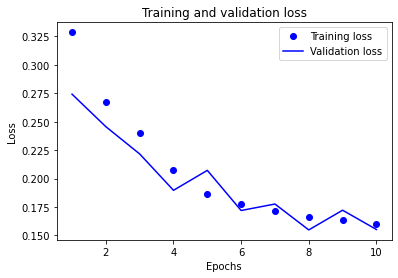

In [5]:
import matplotlib.pyplot as plt

loss_values = history_dict['loss'][0:]
val_loss_values = history_dict['val_loss'][0:]

epochs = range(1, len(loss_values)+1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

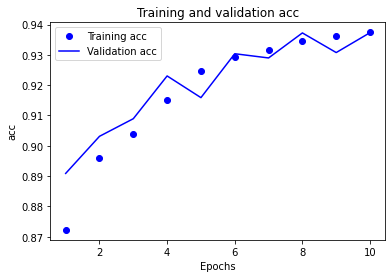

In [6]:
acc_values = history_dict['acc'][0:]
val_acc_values = history_dict['val_acc'][0:]

epochs = range(1, len(acc_values)+1)
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation acc')
plt.xlabel('Epochs')
plt.ylabel('acc')
plt.legend()
plt.show()